In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler

#모델링 모듈
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, average_precision_score, confusion_matrix
import shap
from imblearn.over_sampling import SMOTE

#1. data_load
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
data = pd.read_csv('Churn_Modelling.csv',index_col=0)

#2. data_preprocessing
# missing D(4개 행 제거)
data.isnull().sum()
nan_data = data.dropna()
print('결측 처리 :' ,nan_data.shape)

# duplicated D(2행 제거)
nan_data[nan_data.duplicated()]
new_data = nan_data[~nan_data.duplicated()]
print('중복 처리 :',new_data.shape)

#encoding : gender-label ( Female = 0, male = 1) /  geography-onehot
le = LabelEncoder()
new_data['Gender'] = le.fit_transform(new_data["Gender"])

oe = OneHotEncoder()
oe.fit(new_data[['Geography']])
geo_csr = oe.transform(new_data[['Geography']])
csr_df = pd.DataFrame(geo_csr.toarray(), columns = oe.get_feature_names_out())
df = new_data.reset_index(drop=True)  # df 인덱스 초기화
csr_df = csr_df.reset_index(drop=True)  # csr_df 인덱스 초기화
inco_df = pd.concat([df,csr_df],axis=1)

#check
int_data = inco_df.drop(columns=['CustomerId', 'Surname','Geography'])
X = int_data.drop("Exited", axis=1)
y_true = int_data['Exited']
print('전처리 완료:',X.shape,y_true.shape)
print('----------------------------')

#4.data engineering
#tester split
X_train, X_test, y_train, y_test = train_test_split(X,y_true,stratify = y_true,test_size = 0.3, random_state= 42)
print('데이터 분리 후 크기 : ',X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#minmaxscaling - 적용유무 검토 
target_features = ["CreditScore", "Age", "Balance", "EstimatedSalary"]
X_train_sc = X_train.copy()
X_test_sc = X_test.copy()

mn_sc = MinMaxScaler()
X_train_sc[target_features] = mn_sc.fit_transform(X_train[target_features])
X_test_sc[target_features] = mn_sc.transform(X_test[target_features]) #테스터는 정규화 학습 안함 

#Over Sampling
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_sc, y_train)
print("SMOTE 적용 후 데이터 크기:", X_train_res.shape, y_train_res.shape)
print(f'original : {y_train.value_counts()}')
print(f'smote : {y_train_res.value_counts()}')

print('----------------------------')

결측 처리 : (9998, 13)
중복 처리 : (9996, 13)
전처리 완료: (9996, 12) (9996,)
----------------------------
데이터 분리 후 크기 :  (6997, 12) (2999, 12) (6997,) (2999,)
SMOTE 적용 후 데이터 크기: (11142, 12) (11142,)
original : Exited
0    5571
1    1426
Name: count, dtype: int64
smote : Exited
0    5571
1    5571
Name: count, dtype: int64
----------------------------


In [40]:
# SVM 모델
clf = svm.SVC(kernel='linear',random_state=42)

clf.fit(X_train, y_train)

y_pred_svc = clf.predict(X_test)

print("정확도 : ", accuracy_score(y_test, y_pred_svc))
print("f1-score : ", f1_score(y_test, y_pred_svc))
print("recall : ", recall_score(y_test, y_pred_svc))
print("예측도 : ", precision_score(y_test, y_pred_svc))


정확도 :  0.7842614204734911
f1-score :  0.05822416302765648
recall :  0.03273322422258593
예측도 :  0.2631578947368421


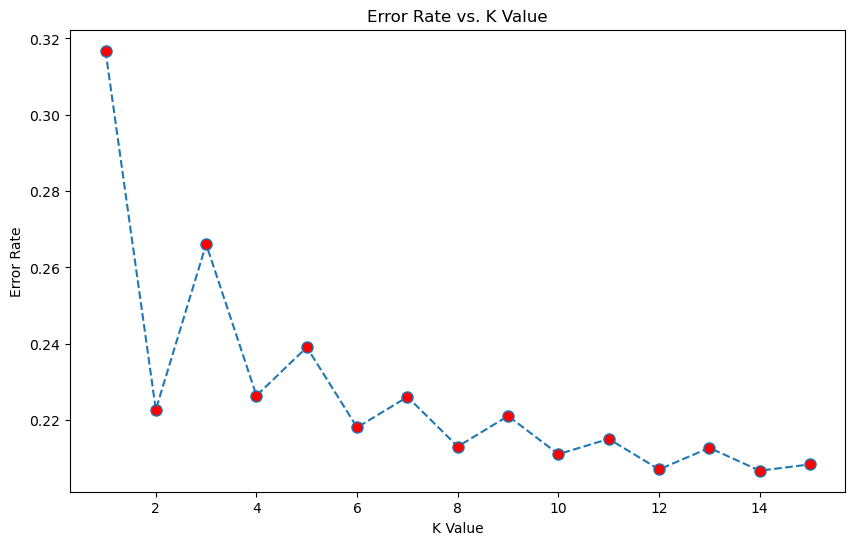

In [41]:
# KNN 모델, 추가 전처리 없을 시 K=14에서 에러율 제일 작음
error_rate = []

for i in range(1, 16):
    knn_i = KNeighborsClassifier(n_neighbors=i)
    knn_i.fit(X_train, y_train)
    y_pred_i = knn_i.predict(X_test)
    error_rate.append(np.mean(y_pred_i != y_test))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), error_rate, marker='o', linestyle='dashed', markersize=8, markerfacecolor='red')
plt.title("Error Rate vs. K Value")
plt.xlabel("K Value")
plt.ylabel("Error Rate")
plt.show()

In [42]:
k = 14
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("정확도 : ", accuracy_score(y_test, y_pred_knn))
print("f1-score : ", f1_score(y_test, y_pred_knn))
print("recall : ", recall_score(y_test, y_pred_knn))
print("예측도 : ", precision_score(y_test, y_pred_knn))

정확도 :  0.7932644214738246
f1-score :  0.022082018927444796
recall :  0.011456628477905073
예측도 :  0.30434782608695654


In [43]:
# 각 모델 정확도를 제외한 모든 수치가 낮아 실사용 불가, optuna를 이용한 튜닝 수행
import optuna
import itertools
import sklearn.svm
import sklearn.model_selection
from sklearn.metrics import classification_report

In [44]:
# SVC optuna 최적화, 목적함수 정의
def objective(trial):

    svc_c = trial.suggest_float("C", 1e-10, 1e10, log=True)
    classifier_obj = sklearn.svm.SVC(C=svc_c, gamma="auto", random_state=42)

    score = sklearn.model_selection.cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-01-31 16:39:06,062] A new study created in memory with name: no-name-da56e353-2e5e-4aaf-ae53-cd278c8af055
[I 2025-01-31 16:39:09,840] Trial 0 finished with value: 0.7961984032514323 and parameters: {'C': 0.11854567859723927}. Best is trial 0 with value: 0.7961984032514323.
[I 2025-01-31 16:39:13,165] Trial 1 finished with value: 0.7961984032514323 and parameters: {'C': 8.87272315882329}. Best is trial 0 with value: 0.7961984032514323.
[I 2025-01-31 16:39:15,059] Trial 2 finished with value: 0.7961984032514323 and parameters: {'C': 3.559216847876317e-09}. Best is trial 0 with value: 0.7961984032514323.
[I 2025-01-31 16:39:18,363] Trial 3 finished with value: 0.7961984032514323 and parameters: {'C': 3581376687.6396403}. Best is trial 0 with value: 0.7961984032514323.
[I 2025-01-31 16:39:20,660] Trial 4 finished with value: 0.7961984032514323 and parameters: {'C': 965080160.1485116}. Best is trial 0 with value: 0.7961984032514323.
[I 2025-01-31 16:39:23,048] Trial 5 finished with 

Number of finished trials: 100
Best trial:
  Value: 0.7961984032514323
  Params: 
    C: 0.11854567859723927


In [45]:
# 최적화된 하이퍼파라미터로 튜닝

svc_c = study.best_params['C']
model = sklearn.svm.SVC(C=svc_c, gamma="auto", random_state=42)
model.fit(X_train, y_train)

y_pred_svc_op = model.predict(X_test)

print("정확도 : ", accuracy_score(y_test, y_pred_svc_op))
print("f1-score : ", f1_score(y_test, y_pred_svc_op))
print("recall : ", recall_score(y_test, y_pred_svc_op))
print("예측도 : ", precision_score(y_test, y_pred_svc_op))

정확도 :  0.7962654218072691
f1-score :  0.0
recall :  0.0
예측도 :  0.0


In [46]:
# KNN 최적화, 목적함수 정의
from sklearn.model_selection import cross_val_score

def obj_knn(trial,x,y):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])

    model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights)
    score = cross_val_score(model, x, y, n_jobs=-1, cv=10, scoring='f1_macro')
    f1_macro = np.mean(score)

    return f1_macro

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(lambda trial: obj_knn(trial, X_train, y_train), n_trials = 100)

# 최적 파라미터 출력
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# 최적 파라미터로 모델 학습
best_params = study.best_trial.params
knn_model = KNeighborsClassifier(**best_params)

[I 2025-01-31 16:47:46,885] A new study created in memory with name: no-name-4b68459f-a104-4503-8e53-1168edfc7cd1
[I 2025-01-31 16:47:49,318] Trial 0 finished with value: 0.4520501834255065 and parameters: {'n_neighbors': 12, 'metric': 'euclidean', 'weights': 'uniform'}. Best is trial 0 with value: 0.4520501834255065.
[I 2025-01-31 16:47:50,409] Trial 1 finished with value: 0.5043945595685833 and parameters: {'n_neighbors': 2, 'metric': 'euclidean', 'weights': 'distance'}. Best is trial 1 with value: 0.5043945595685833.
[I 2025-01-31 16:47:50,481] Trial 2 finished with value: 0.465604279424471 and parameters: {'n_neighbors': 25, 'metric': 'euclidean', 'weights': 'distance'}. Best is trial 1 with value: 0.5043945595685833.
[I 2025-01-31 16:47:50,531] Trial 3 finished with value: 0.4745001429750131 and parameters: {'n_neighbors': 13, 'metric': 'manhattan', 'weights': 'distance'}. Best is trial 1 with value: 0.5043945595685833.
[I 2025-01-31 16:47:50,620] Trial 4 finished with value: 0.45

Best trial:
  Value: 0.5133756034027371
  Params: 
    n_neighbors: 3
    metric: manhattan
    weights: uniform


In [47]:
# bset parmeter training
knn_model.fit(X_train,y_train)
y_pred_knn_op = knn_model.predict(X_test)

print("정확도 : ", accuracy_score(y_test, y_pred_knn_op))
print("f1-score : ", f1_score(y_test, y_pred_knn_op))
print("recall : ", recall_score(y_test, y_pred_knn_op))
print("예측도 : ", precision_score(y_test, y_pred_knn_op))

정확도 :  0.7432477492497499
f1-score :  0.17558886509635974
recall :  0.1342062193126023
예측도 :  0.25386996904024767
